In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Import libaray
import os, random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, f1_score,
    roc_auc_score, roc_curve, auc
)

import seaborn as sns
import wandb

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
CONFIG = {
    "model": "densenet121",
    "batch_size": 32,
    "learning_rate_head": 1e-4,
    "learning_rate_ft": 1e-5,
    "epochs_head": 10,
    "epochs_ft": 30,
    "num_workers": 2,
    "device": "mps" if torch.backends.mps.is_available()
              else "cuda" if torch.cuda.is_available() else "cpu",
    "model": "densenet121",
    "batch_size": 16,
    "learning_rate_head": 1e-4,
    "learning_rate_ft": 1e-5,
    "epochs_head": 5,
    "epochs_ft": 10,
    "num_workers": 2,
    "device": "mps" if torch.backends.mps.is_available()
              else "cuda" if torch.cuda.is_available() else "cpu",
    "data_dir": "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset",
    "wandb_project": "X-Ray Classification Using CNN",
    "patience": 5,              # (để sẵn nếu bạn muốn early stopping)
    "seed": 42,
    "image_size": 224,
    "val_size": 0.15,
    "test_size": 0.10,
    "weight_decay_head": 1e-4,
    "weight_decay_ft": 1e-5,
    "save_path": "best_densenet121_4class.pth",
    "roc_log_every": 1,          # log ROC mỗi epoch (đổi 2/3 để nhẹ hơn)
    "wandb_project": "X-Ray Classification Using CNN",
    "patience": 5,              # (để sẵn nếu bạn muốn early stopping)
    "seed": 42,
    "image_size": 224,
    "val_size": 0.15,
    "test_size": 0.10,
    "weight_decay_head": 1e-4,
    "weight_decay_ft": 1e-5,
    "save_path": "best_densenet121_4class.pth",
    "roc_log_every": 1,          # log ROC mỗi epoch (đổi 2/3 để nhẹ hơn)
}

In [3]:
classes = ["COVID", "Normal", "Viral Pneumonia", "Lung_Opacity"]
NUM_CLASSES = len(classes)

device = torch.device(CONFIG["device"])
print("Device:", device)

Device: cuda


In [4]:
# 2 SEED
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CONFIG["seed"])


In [5]:
# BUILD DATAFRAME
DATA_DIR = CONFIG["data_dir"]

paths, labels = [], []
for label_idx, cls in enumerate(classes):
    folder = os.path.join(DATA_DIR, cls, "images")
    if not os.path.exists(folder):
        print(f"Không tìm thấy thư mục: {folder}")
        continue

    for img_name in os.listdir(folder):
        if img_name.lower().endswith(".png"):
            paths.append(os.path.join(folder, img_name))
            labels.append(label_idx)

df = pd.DataFrame({"image": paths, "label": labels})
print(df["label"].value_counts())
print("Tổng số ảnh:", len(df))

label
1    10192
3     6012
0     3616
2     1345
Name: count, dtype: int64
Tổng số ảnh: 21165


In [6]:
# TRAIN / VAL / TEST SPLIT (stratify)
trainval_df, test_df = train_test_split(
    df,
    test_size=CONFIG["test_size"],
    stratify=df["label"],
    random_state=CONFIG["seed"]
)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=CONFIG["val_size"],
    stratify=trainval_df["label"],
    random_state=CONFIG["seed"]
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 16190, Val: 2858, Test: 2117


In [7]:
# TRANSFORMS
train_tfms = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((CONFIG["image_size"], CONFIG["image_size"])),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [8]:
# DATASET / DATALOADER
class ChestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "image"]
        label = int(self.df.loc[idx, "label"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

train_ds = ChestDataset(train_df, train_tfms)
val_ds   = ChestDataset(val_df, eval_tfms)
test_ds  = ChestDataset(test_df, eval_tfms)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True,  num_workers=CONFIG["num_workers"])
val_loader   = DataLoader(val_ds,   batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
test_loader  = DataLoader(test_ds,  batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])


In [9]:
# CLASS WEIGHTS
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label"]),
    y=df["label"]
)
class_weights = torch.tensor(weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([1.4633, 0.5192, 3.9340, 0.8801], device='cuda:0')


In [10]:
# MODEL
def build_model():
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(512, NUM_CLASSES)
    )
    return model

model = build_model().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
# METRICS + HELPERS
def softmax_probs(logits: torch.Tensor) -> np.ndarray:
    return torch.softmax(logits, dim=1).detach().cpu().numpy()

def compute_epoch_metrics(y_true, y_pred, y_proba):
    """
    y_true: list[int]
    y_pred: list[int]
    y_proba: np.ndarray shape [N, C]
    """
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")

    # Multi-class AUC (OVR macro)
    auc_score = None
    try:
        auc_score = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
    except Exception:
        auc_score = np.nan

    return acc, f1, auc_score

def plot_multiclass_roc(y_true, y_proba, class_names):
    """
    Trả về matplotlib Figure ROC OVR cho từng class
    """
    y_true = np.array(y_true)
    fig = plt.figure(figsize=(7, 6))
    for c in range(len(class_names)):
        # binary ground truth for class c
        y_bin = (y_true == c).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_proba[:, c])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[c]} (AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    return fig

In [12]:
# TRAIN / VALIDATE LOOPS 
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total = 0.0, 0
    y_true, y_pred = [], []

    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        total += labels.size(0)

        preds = torch.argmax(out, dim=1)
        y_true.extend(labels.detach().cpu().numpy().tolist())
        y_pred.extend(preds.detach().cpu().numpy().tolist())

    avg_loss = total_loss / total
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc

In [13]:
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total = 0.0, 0
    y_true, y_pred = [], []
    proba_all = []

    for imgs, labels in tqdm(loader, desc="Eval", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        loss = criterion(out, labels)

        total_loss += loss.item() * imgs.size(0)
        total += labels.size(0)

        probs = softmax_probs(out)
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.detach().cpu().numpy().tolist())
        y_pred.extend(preds.tolist())
        proba_all.append(probs)

    avg_loss = total_loss / total
    y_proba = np.concatenate(proba_all, axis=0)
    acc, f1, auc_score = compute_epoch_metrics(y_true, y_pred, y_proba)
    return avg_loss, acc, f1, auc_score, y_true, y_pred, y_proba


def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

In [16]:
wandb.login(key="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")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


ValueError: API key must be 40 characters long, yours was 86

In [17]:
# WANDB INIT
wandb.init(project=CONFIG["wandb_project"], config=CONFIG)
wandb.watch(model, log="all")
wandb.run.id

wandb: Currently logged in as: nguyenthidinh652 (nguyenthidinh652-fpt-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


'40t5yxc8'

In [18]:
# PHASE 1 – TRAIN HEAD
best_val_acc = 0.0

# freeze backbone, train head
for p in model.parameters():
    p.requires_grad = False
for p in model.classifier.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.classifier.parameters(),
                        lr=CONFIG["learning_rate_head"],
                        weight_decay=CONFIG["weight_decay_head"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

global_epoch = 0

for epoch in range(CONFIG["epochs_head"]):
    global_epoch += 1

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1, val_auc, yv_true, yv_pred, yv_proba = evaluate(model, val_loader, criterion)

    scheduler.step(val_loss)

    log_dict = {
        "phase": 1,
        "epoch": global_epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": train_acc,
        "val_accuracy": val_acc,
        "f1": val_f1,
        "auc": val_auc,
        "lr": get_lr(optimizer),
    }

    # ROC figure
    if (epoch + 1) % CONFIG["roc_log_every"] == 0:
        fig = plot_multiclass_roc(yv_true, yv_proba, classes)
        log_dict["roc"] = wandb.Image(fig)
        plt.close(fig)

    wandb.log(log_dict)

    print(f"[Phase 1] Epoch {epoch+1}/{CONFIG['epochs_head']} | "
          f"TrainAcc {train_acc:.3f} | ValAcc {val_acc:.3f} | ValF1 {val_f1:.3f} | ValAUC {val_auc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CONFIG["save_path"])
        wandb.save(CONFIG["save_path"])
        print("💾 Saved best Phase 1 model")



[Phase 1] Epoch 1/5 | TrainAcc 0.688 | ValAcc 0.795 | ValF1 0.778 | ValAUC 0.944
💾 Saved best Phase 1 model


[Phase 1] Epoch 2/5 | TrainAcc 0.760 | ValAcc 0.795 | ValF1 0.787 | ValAUC 0.950
💾 Saved best Phase 1 model


[Phase 1] Epoch 3/5 | TrainAcc 0.776 | ValAcc 0.794 | ValF1 0.792 | ValAUC 0.954


[Phase 1] Epoch 4/5 | TrainAcc 0.791 | ValAcc 0.817 | ValF1 0.816 | ValAUC 0.958
💾 Saved best Phase 1 model


[Phase 1] Epoch 5/5 | TrainAcc 0.798 | ValAcc 0.826 | ValF1 0.822 | ValAUC 0.960
💾 Saved best Phase 1 model


In [ ]:
# PHASE 2 – FINE-TUNE FULL
for p in model.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(),
                        lr=CONFIG["learning_rate_ft"],
                        weight_decay=CONFIG["weight_decay_ft"])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG["epochs_ft"])

for epoch in range(CONFIG["epochs_ft"]):
    global_epoch += 1

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_f1, val_auc, yv_true, yv_pred, yv_proba = evaluate(model, val_loader, criterion)

    scheduler.step()

    log_dict = {
        "phase": 2,
        "epoch": global_epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "accuracy": train_acc,
        "val_accuracy": val_acc,
        "f1": val_f1,
        "auc": val_auc,
        "lr": get_lr(optimizer),
    }

    if (epoch + 1) % CONFIG["roc_log_every"] == 0:
        fig = plot_multiclass_roc(yv_true, yv_proba, classes)
        log_dict["roc"] = wandb.Image(fig)
        plt.close(fig)

    wandb.log(log_dict)

    print(f"[Phase 2] Epoch {epoch+1}/{CONFIG['epochs_ft']} | "
          f"TrainAcc {train_acc:.3f} | ValAcc {val_acc:.3f} | ValF1 {val_f1:.3f} | ValAUC {val_auc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), CONFIG["save_path"])
        wandb.save(CONFIG["save_path"])
        print("💾 Saved best Phase 2 model")


✅ Loading best model for TEST evaluation...



===== TEST METRICS =====
Test Loss: 0.1207
Test Acc : 0.9532
Test F1  : 0.9620 (macro)
Test AUC : 0.9947 (macro OVR)


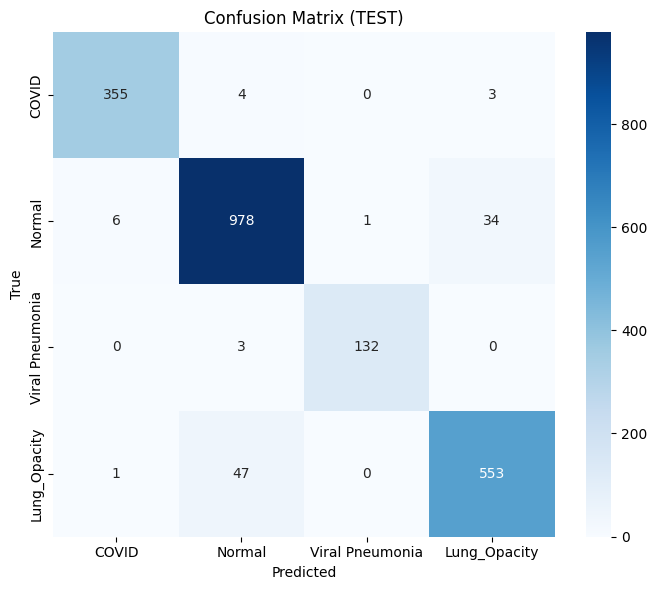


===== CLASSIFICATION REPORT (TEST) =====
                 precision    recall  f1-score   support

          COVID       0.98      0.98      0.98       362
         Normal       0.95      0.96      0.95      1019
Viral Pneumonia       0.99      0.98      0.99       135
   Lung_Opacity       0.94      0.92      0.93       601

       accuracy                           0.95      2117
      macro avg       0.96      0.96      0.96      2117
   weighted avg       0.95      0.95      0.95      2117



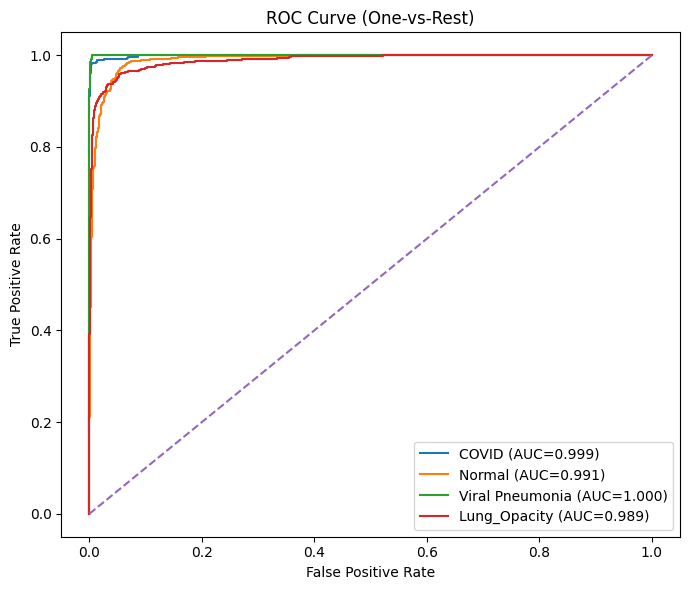

accuracy,▁▃▃▄▄▆▇▇▇██████
auc,▁▂▂▃▃▇▇████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
f1,▁▁▂▂▃▆▇▇▇▇█████
lr,█████▂▂▂▁▁▁▁▁▁▁
phase,▁▁▁▁▁██████████
test_accuracy,▁
test_auc,▁
test_f1,▁
test_loss,▁
+3,...


In [20]:
# LOAD BEST + TEST EVALUATION
print("\n✅ Loading best model for TEST evaluation...")
model.load_state_dict(torch.load("/kaggle/working/best_densenet121_4class.pth", map_location=device))

test_loss, test_acc, test_f1, test_auc, yt_true, yt_pred, yt_proba = evaluate(model, test_loader, criterion)

print("\n===== TEST METRICS =====")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")
print(f"Test F1  : {test_f1:.4f} (macro)")
print(f"Test AUC : {test_auc:.4f} (macro OVR)")

# Confusion Matrix
cm = confusion_matrix(yt_true, yt_pred, labels=list(range(NUM_CLASSES)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (TEST)")
plt.tight_layout()

# log confusion matrix as image
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc,
    "test_f1": test_f1,
    "test_auc": test_auc,
    "test_confusion_matrix": wandb.Image(plt.gcf())
})
plt.show()
plt.close()

# Classification report (log text)
report = classification_report(yt_true, yt_pred, target_names=classes, zero_division=0)
print("\n===== CLASSIFICATION REPORT (TEST) =====")
print(report)
wandb.log({"test_classification_report": wandb.Html(f"<pre>{report}</pre>")})

# ROC curve test
fig = plot_multiclass_roc(yt_true, yt_proba, classes)
wandb.log({"test_roc": wandb.Image(fig)})
plt.show()
plt.close(fig)

# Save again (ensure artifact exists on wandb)
wandb.save(CONFIG["save_path"])

wandb.finish()